In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import re
from pandas import *
import matplotlib.pyplot as plt
%matplotlib inline
from qiime2.plugins import feature_table
from qiime2 import Artifact
from qiime2 import Metadata
import biom
from biom.table import Table
from qiime2.plugins import diversity
from scipy.stats import ttest_ind
from scipy.stats.stats import pearsonr
%config InlineBackend.figure_formats = ['svg']
from qiime2.plugins.feature_table.methods import relative_frequency
import biom
import qiime2 as q2
import os
import math

/anaconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/ten

# Import and prepare dataframes for analysis

In [2]:
# import metadata
meta = q2.Metadata.load('filtered-metadata.qza').to_dataframe()

In [3]:
# import data to plot (relative abundance table collapsed to the genus level) 
fec6 = pd.read_csv('rel-phyla-table.tsv', sep='\t', index_col=0)

In [4]:
# melt the table so that we can use it later as we want
melt = fec6.unstack()
fec6s = pd.DataFrame(melt)

In [5]:
fec6s.reset_index(inplace=True)
fec6s.rename(columns={'level_0':'sample','#OTU ID':'taxa',0:'counts'}, inplace=True)

# None, Fresh, Ambient BL figures

### Correlation graphs (all pres.)

In [ ]:
#for these conditions we will use the fresh samples as baseline
#thus within each preservative, the baseline samples are fresh,amb

#list of metadata preservative subgroups to create graphs for (6)
pres_sep = [] 

#list of baselines
bl = []

#keep dataframes for each preservation method, except None
for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    pres_sep.append(preservation_df)

for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    if preservation == 'None':
        #create amb, fresh baseline for each preservative (all fresh are also amb)
        amb_fresh_bl = preservation_df[preservation_df.duration_of_storage == 'fresh']
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)

#list of preservative and temperature subgroups with their baseline samples
subsets_w_bl = {}

for etoh70_df, etoh70_bl in zip(pres_sep, bl):
    #create list of temperature subgroups with their baseline samples
    
    for (pres, temp), temperature_df in etoh70_df.groupby(['sample_preservation_method',
                                                           'sample_storage_temp_treatment_week_added']):
        new_df = pd.concat([etoh70_bl,temperature_df])
        subsets_w_bl[(pres, temp)] = new_df

In [ ]:
list_of_lists = []

for key, value in subsets_w_bl.items():
    
    string =  ' '.join(key)
    
    #merge metadata subsets with baseline with taxonomy
    metafec6 = pd.merge(value, fec6s, left_index=True, right_on='sample')

    #create new column 
    metafec6['taxa_subject'] = metafec6['taxa'] + metafec6['host_subject_id']

    #subtract out duplicates and pivot
    df = metafec6.drop_duplicates(subset = ['taxa_subject', 'duration_of_storage'], keep = 'first')
    fecpiv = df.pivot(index='taxa_subject', columns='duration_of_storage', values='counts')
    fecpiv_no_na = fecpiv.dropna()

    # check pearson correlation
    x = fecpiv_no_na['fresh']
    y = fecpiv_no_na['8weeks']
    corr = stats.pearsonr(x, y)
    int1, int2 = corr
    corr_rounded = round(int1, 2)
    corr_str = str(corr_rounded)
    x_key = key[0]
    y_key = key[1]
    
    list1 = []

    list1.append(corr_rounded)
    list1.append(key[0])
    list1.append(key[1])
    list_of_lists.append(list1)
        

In [ ]:
df = pd.DataFrame(list_of_lists, columns = ['Correlation', 'Preservative', 'Temperature']) 

In [ ]:
splot = sns.catplot(y="Correlation", x="Preservative", hue= "Temperature", kind='bar',
                    data=df)  

splot.set(ylim=(0, 1))
splot.savefig('correlation_none_fresh_amb_bl.png')
splot.savefig('correlation_none_fresh_amb_bl.svg', format='svg', dpi=1200)

### Correlation graphs (select graphs)

In [ ]:
#for these conditions we will use the fresh samples as baseline
#thus within each preservative, the baseline samples are fresh,amb

#list of metadata preservative subgroups to create graphs for (6)
pres_sep = [] 

#list of baselines
bl = []

#keep dataframes for each preservation method, except None
for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    pres_sep.append(preservation_df)

for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    if preservation == 'None':
        #create amb, fresh baseline for each preservative (all fresh are also amb)
        amb_fresh_bl = preservation_df[preservation_df.duration_of_storage == 'fresh']
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)

#list of preservative and temperature subgroups with their baseline samples
subsets_w_bl = {}

for etoh70_df, etoh70_bl in zip(pres_sep, bl):
    #create list of temperature subgroups with their baseline samples
    
    for (pres, temp), temperature_df in etoh70_df.groupby(['sample_preservation_method',
                                                           'sample_storage_temp_treatment_week_added']):
        new_df = pd.concat([etoh70_bl,temperature_df])
        subsets_w_bl[(pres, temp)] = new_df

In [ ]:
list_of_lists = []

for key, value in subsets_w_bl.items():
    
    string =  ' '.join(key)
    
    #merge metadata subsets with baseline with taxonomy
    metafec6 = pd.merge(value, fec6s, left_index=True, right_on='sample')

    #create new column 
    metafec6['taxa_subject'] = metafec6['taxa'] + metafec6['host_subject_id']

    #subtract out duplicates and pivot
    df = metafec6.drop_duplicates(subset = ['taxa_subject', 'duration_of_storage'], keep = 'first')
    fecpiv = df.pivot(index='taxa_subject', columns='duration_of_storage', values='counts')
    fecpiv_no_na = fecpiv.dropna()

    # check pearson correlation
    x = fecpiv_no_na['fresh']
    y = fecpiv_no_na['8weeks']
    corr = stats.pearsonr(x, y)
    int1, int2 = corr
    corr_rounded = round(int1, 2)
    corr_str = str(corr_rounded)
    x_key = key[0]
    y_key = key[1]
    
    list1 = []
    
    if x_key == '95etoh':
        if key[1] != '20C after one week':
            list1.append(corr_rounded)
            list1.append(key[0])
            list1.append(key[1])
            list_of_lists.append(list1)
    if x_key == 'None':
        list1.append(corr_rounded)
        list1.append(key[0])
        list1.append(key[1])
        list_of_lists.append(list1)

In [ ]:
df = pd.DataFrame(list_of_lists, columns = ['Correlation', 'Preservative', 'Temperature']) 
splot = sns.catplot(y="Correlation", x="Preservative", hue= "Temperature", kind='bar',
                    data=df,aspect=.7)  
splot.set(ylim=(0, 1))
splot.savefig('correlation_none_fresh_amb_bl-figure.png')
splot.savefig('correlation_none_fresh_amb_bl-figure.svg', format='svg', dpi=1200)

# Fresh, Ambient BL figures

### Correlation graphs (all preservatives)

In [ ]:
#for these conditions we will use the fresh samples as baseline
#thus within each preservative, the baseline samples are fresh,amb

#list of metadata preservative subgroups to create graphs for (6)
pres_sep = [] 

#list of baselines
bl = []

#keep dataframes for each preservation method, except None
for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    pres_sep.append(preservation_df)

    #create amb, fresh baseline for each preservative (all fresh are also amb)
    amb_fresh_bl = preservation_df[preservation_df.duration_of_storage == 'fresh']
    bl.append(amb_fresh_bl)

#list of preservative and temperature subgroups with their baseline samples
subsets_w_bl = {}

for etoh70_df, etoh70_bl in zip(pres_sep, bl):    
    #create list of temperature subgroups with their baseline samples
    
    for (pres, temp), temperature_df in etoh70_df.groupby(['sample_preservation_method',
                                                           'sample_storage_temp_treatment_week_added']):
        new_df = pd.concat([etoh70_bl,temperature_df])
        subsets_w_bl[(pres, temp)] = new_df

In [ ]:
list_of_lists = []

for key, value in subsets_w_bl.items():
    
    string =  ' '.join(key)
    
    #merge metadata subsets with baseline with taxonomy
    metafec6 = pd.merge(value, fec6s, left_index=True, right_on='sample')

    #create new column 
    metafec6['taxa_subject'] = metafec6['taxa'] + metafec6['host_subject_id']

    #subtract out duplicates and pivot
    df = metafec6.drop_duplicates(subset = ['taxa_subject', 'duration_of_storage'], keep = 'first')
    fecpiv = df.pivot(index='taxa_subject', columns='duration_of_storage', values='counts')
    fecpiv_no_na = fecpiv.dropna()

    # check pearson correlation
    x = fecpiv_no_na['fresh']
    y = fecpiv_no_na['8weeks']
    corr = stats.pearsonr(x, y)
    int1, int2 = corr
    corr_rounded = round(int1, 2)
    corr_str = str(corr_rounded)
    x_key = key[0]
    y_key = key[1]
    
    list1 = []
    
    list1.append(corr_rounded)
    list1.append(key[0])
    list1.append(key[1])
    list_of_lists.append(list1)
        

In [ ]:
df = pd.DataFrame(list_of_lists, columns = ['Correlation', 'Preservative', 'Temperature']) 

In [ ]:
splot = sns.catplot(y="Correlation", x="Preservative", hue= "Temperature", kind='bar',
                    data=df)
splot.set(ylim=(0, 1))

new_labels = ['−20C','4C','Ambient','Freeze-thaw','Heat']
for t, l in zip(splot._legend.texts, new_labels):
    t.set_text(l)
        
splot.savefig('correlation_fresh_amb_bl.png')
splot.savefig('correlation_fresh_amb_bl.svg', format='svg', dpi=1200)

### Correlation graphs (select graphs)

In [ ]:
#for these conditions we will use the fresh samples as baseline
#thus within each preservative, the baseline samples are fresh,amb

#list of metadata preservative subgroups to create graphs for (6)
pres_sep = [] 

#list of baselines
bl = []

#keep dataframes for each preservation method, except None
for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    pres_sep.append(preservation_df)

    #create amb, fresh baseline for each preservative (all fresh are also amb)
    amb_fresh_bl = preservation_df[preservation_df.duration_of_storage == 'fresh']
    bl.append(amb_fresh_bl)

#list of preservative and temperature subgroups with their baseline samples
subsets_w_bl = {}

for etoh70_df, etoh70_bl in zip(pres_sep, bl):    
    #create list of temperature subgroups with their baseline samples
    
    for (pres, temp), temperature_df in etoh70_df.groupby(['sample_preservation_method',
                                                           'sample_storage_temp_treatment_week_added']):
        new_df = pd.concat([etoh70_bl,temperature_df])
        subsets_w_bl[(pres, temp)] = new_df

In [ ]:
list_of_lists = []

for key, value in subsets_w_bl.items():
    
    string =  ' '.join(key)
    
    #merge metadata subsets with baseline with taxonomy
    metafec6 = pd.merge(value, fec6s, left_index=True, right_on='sample')

    #create new column 
    metafec6['taxa_subject'] = metafec6['taxa'] + metafec6['host_subject_id']

    #subtract out duplicates and pivot
    df = metafec6.drop_duplicates(subset = ['taxa_subject', 'duration_of_storage'], keep = 'first')
    fecpiv = df.pivot(index='taxa_subject', columns='duration_of_storage', values='counts')
    fecpiv_no_na = fecpiv.dropna()

    # check pearson correlation
    x = fecpiv_no_na['fresh']
    y = fecpiv_no_na['8weeks']
    corr = stats.pearsonr(x, y)
    int1, int2 = corr
    corr_rounded = round(int1, 2)
    corr_str = str(corr_rounded)
    x_key = key[0]
    y_key = key[1]
    
    list1 = []
    
    if x_key == '95etoh':
        if key[1] != '20C after one week':
            list1.append(corr_rounded)
            list1.append(key[0])
            list1.append(key[1])
            list_of_lists.append(list1)
    if x_key == 'None':
        list1.append(corr_rounded)
        list1.append(key[0])
        list1.append(key[1])
        list_of_lists.append(list1)
        

In [ ]:
df = pd.DataFrame(list_of_lists, columns = ['Correlation', 'Preservative', 'Temperature']) 
splot = sns.catplot(y="Correlation", x="Preservative", hue= "Temperature", kind='bar',
                    data=df,aspect=.7)
splot.set(ylim=(0, 1))

new_labels = ['−20C','4C','Ambient','Freeze-thaw','Heat']
for t, l in zip(splot._legend.texts, new_labels):
    t.set_text(l)
        
splot.savefig('correlation_fresh_amb_bl-figure.png')
splot.savefig('correlation_fresh_amb_bl-figure.svg', format='svg', dpi=1200)

# Relative abundance (Blooms) 

###  none amb fresh as bl

In [ ]:
#for these conditions we will use the fresh samples as baseline
#thus within each preservative, the baseline samples are fresh,amb

#list of metadata preservative subgroups to create graphs for (6)
pres_sep = [] 

#list of baselines
bl = []

#keep dataframes for each preservation method, except None
for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    pres_sep.append(preservation_df)

for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    if preservation == 'None':
        #create amb, fresh baseline for each preservative (all fresh are also amb)
        amb_fresh_bl = preservation_df[preservation_df.duration_of_storage == 'fresh']
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)

#list of preservative and temperature subgroups with their baseline samples
subsets_w_bl = {}

for etoh70_df, etoh70_bl in zip(pres_sep, bl):
    #create list of temperature subgroups with their baseline samples
    
    for (pres, temp), temperature_df in etoh70_df.groupby(['sample_preservation_method',
                                                           'sample_storage_temp_treatment_week_added']):
        if temp == 'amb':
            new_df = pd.concat([etoh70_bl,temperature_df])
            subsets_w_bl[(pres, temp)] = new_df

In [ ]:
tidy_data = []

for key, value in subsets_w_bl.items():
    
    string =  ' '.join(key)
    
    #merge metadata subsets with baseline with taxonomy
    metafec6 = pd.merge(value, fec6s, left_index=True, right_on='sample')

    #create new column 
    metafec6['taxa_subject'] = metafec6['taxa'] + metafec6['host_subject_id']

    #subtract out duplicates and pivot
    df = metafec6.drop_duplicates(subset = ['taxa_subject', 'duration_of_storage'], keep = 'first')
    fecpiv = df.pivot(index='taxa_subject', columns='duration_of_storage', values='counts')
    
    cols = ['1week', '4weeks', '8weeks', 'fresh']
    fecpiv1 = fecpiv[fecpiv[cols] > 0.0005].dropna()
    denominator = fecpiv1.shape[0]
    
    fecpiv1['fc_1wk']=fecpiv1.apply(lambda row: row['1week'] / row['fresh'], axis=1)
    fecpiv1['fc_4wk']=fecpiv1.apply(lambda row: row['4weeks'] / row['fresh'], axis=1)
    fecpiv1['fc_8wk']=fecpiv1.apply(lambda row: row['8weeks'] / row['fresh'], axis=1)
    
    fecpiv_1wk = fecpiv1[fecpiv1['fc_1wk'] > 10]
    fecpiv_1wk.drop(['fc_4wk','fc_8wk'], axis=1)
    numerator_1wk = fecpiv_1wk.shape[0]
    fc_1wk = numerator_1wk / denominator

    fecpiv_4wk = fecpiv1[fecpiv1['fc_4wk'] > 10]
    fecpiv_4wk.drop(['fc_1wk','fc_8wk'], axis=1)
    numerator_4wk = fecpiv_4wk.shape[0]
    fc_4wk = numerator_4wk / denominator

    fecpiv_8wk = fecpiv1[fecpiv1['fc_8wk'] > 10]
    fecpiv_8wk.drop(['fc_4wk','fc_1wk'], axis=1)
    numerator_8wk = fecpiv_8wk.shape[0]
    fc_8wk = numerator_8wk / denominator
    
    fc_df = pd.DataFrame([[0, 'fresh', string],
                          [fc_1wk, '1week' , string],
                          [fc_4wk, '4weeks', string],
                          [fc_8wk, '8weeks', string]],
                          columns=['value','time','group']).set_index('group')
    
    tidy_data.append(fc_df)
    
tidy_data = pd.concat(tidy_data)

In [ ]:
tidy_data['test']=0

In [ ]:
tidy_data = tidy_data.reset_index().set_index('test')

In [ ]:
#for these conditions we will use the fresh samples as baseline
#thus within each preservative, the baseline samples are fresh,amb

#list of metadata preservative subgroups to create graphs for (6)
pres_sep = [] 

#list of baselines
bl = []

#keep dataframes for each preservation method, except None
for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    if preservation == 'None':
        pres_sep.append(preservation_df)

        #create amb, fresh baseline for each preservative (all fresh are also amb)
        amb_fresh_bl = preservation_df[preservation_df.duration_of_storage == 'fresh']
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)

#list of preservative and temperature subgroups with their baseline samples
subsets_w_bl = {}

for etoh70_df, etoh70_bl in zip(pres_sep, bl):    
    #create list of temperature subgroups with their baseline samples
    
    for (pres, temp), temperature_df in etoh70_df.groupby(['sample_preservation_method',
                                                           'sample_storage_temp_treatment_week_added']):
        if temp == '20C':
            new_df = pd.concat([etoh70_bl,temperature_df])
            subsets_w_bl[(pres, temp)] = new_df

In [ ]:
tidy_data2 = []

for key, value in subsets_w_bl.items():
    
    string =  ' '.join(key)
    
    #merge metadata subsets with baseline with taxonomy
    metafec6 = pd.merge(value, fec6s, left_index=True, right_on='sample')

    #create new column 
    metafec6['taxa_subject'] = metafec6['taxa'] + metafec6['host_subject_id']

    #subtract out duplicates and pivot
    df = metafec6.drop_duplicates(subset = ['taxa_subject', 'duration_of_storage'], keep = 'first')
    fecpiv = df.pivot(index='taxa_subject', columns='duration_of_storage', values='counts')
    
    cols = ['1week', '4weeks', '8weeks', 'fresh']
    fecpiv1 = fecpiv[fecpiv[cols] > 0.0005].dropna()
    denominator = fecpiv1.shape[0]
    
    fecpiv1['fc_1wk']=fecpiv1.apply(lambda row: row['1week'] / row['fresh'], axis=1)
    fecpiv1['fc_4wk']=fecpiv1.apply(lambda row: row['4weeks'] / row['fresh'], axis=1)
    fecpiv1['fc_8wk']=fecpiv1.apply(lambda row: row['8weeks'] / row['fresh'], axis=1)
    
    fecpiv_1wk = fecpiv1[fecpiv1['fc_1wk'] > 10]
    fecpiv_1wk.drop(['fc_4wk','fc_8wk'], axis=1)
    numerator_1wk = fecpiv_1wk.shape[0]
    fc_1wk = numerator_1wk / denominator

    fecpiv_4wk = fecpiv1[fecpiv1['fc_4wk'] > 10]
    fecpiv_4wk.drop(['fc_1wk','fc_8wk'], axis=1)
    numerator_4wk = fecpiv_4wk.shape[0]
    fc_4wk = numerator_4wk / denominator

    fecpiv_8wk = fecpiv1[fecpiv1['fc_8wk'] > 10]
    fecpiv_8wk.drop(['fc_4wk','fc_1wk'], axis=1)
    numerator_8wk = fecpiv_8wk.shape[0]
    fc_8wk = numerator_8wk / denominator
    
    fc_df = pd.DataFrame([[0, 'fresh', string],
                          [fc_1wk, '1week' , string],
                          [fc_4wk, '4weeks', string],
                          [fc_8wk, '8weeks', string]],
                          columns=['value','time','group']).set_index('group')
    
    tidy_data2.append(fc_df)
    
tidy_data2 = pd.concat(tidy_data2)

In [ ]:
tidy_data2['test']=0
tidy_data2 = tidy_data2.reset_index().set_index('test')
tidy_data3 = pd.concat([tidy_data,tidy_data2])

In [ ]:
graph = sns.catplot(x="time", y="value", kind="point", hue='group', data=tidy_data3, order=['1week', '4weeks', '8weeks'])
graph.set(ylim=(-.01, 0.12))
graph.savefig('blooms_none_fresh_amb_bl.png')
graph.savefig('blooms_none_fresh_amb_bl.svg', format='svg', dpi=1200)

### fresh, amb baseline

In [6]:
#for these conditions we will use the fresh samples as baseline
#thus within each preservative, the baseline samples are fresh,amb

#list of metadata preservative subgroups to create graphs for (6)
pres_sep = [] 

#list of baselines
bl = []

#keep dataframes for each preservation method, except None
for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    pres_sep.append(preservation_df)

    #create amb, fresh baseline for each preservative (all fresh are also amb)
    amb_fresh_bl = preservation_df[preservation_df.duration_of_storage == 'fresh']
    bl.append(amb_fresh_bl)

#list of preservative and temperature subgroups with their baseline samples
subsets_w_bl = {}

for etoh70_df, etoh70_bl in zip(pres_sep, bl):    
    #create list of temperature subgroups with their baseline samples
    
    for (pres, temp), temperature_df in etoh70_df.groupby(['sample_preservation_method',
                                                           'sample_storage_temp_treatment_week_added']):
        if temp == 'amb':
            new_df = pd.concat([etoh70_bl,temperature_df])
            subsets_w_bl[(pres, temp)] = new_df

In [7]:
tidy_data = []

for key, value in subsets_w_bl.items():
    
    string =  ' '.join(key)
    
    #merge metadata subsets with baseline with taxonomy
    metafec6 = pd.merge(value, fec6s, left_index=True, right_on='sample')

    #create new column 
    metafec6['taxa_subject'] = metafec6['taxa'] + metafec6['host_subject_id']

    #subtract out duplicates and pivot
    df = metafec6.drop_duplicates(subset = ['taxa_subject', 'duration_of_storage'], keep = 'first')
    fecpiv = df.pivot(index='taxa_subject', columns='duration_of_storage', values='counts')
    
    cols = ['1week', '4weeks', '8weeks', 'fresh']
    fecpiv1 = fecpiv[fecpiv[cols] > 0.0005].dropna()
    denominator = fecpiv1.shape[0]
    
    fecpiv1['fc_1wk']=fecpiv1.apply(lambda row: row['1week'] / row['fresh'], axis=1)
    fecpiv1['fc_4wk']=fecpiv1.apply(lambda row: row['4weeks'] / row['fresh'], axis=1)
    fecpiv1['fc_8wk']=fecpiv1.apply(lambda row: row['8weeks'] / row['fresh'], axis=1)
    
    fecpiv_1wk = fecpiv1[fecpiv1['fc_1wk'] > 10]
    fecpiv_1wk.drop(['fc_4wk','fc_8wk'], axis=1)
    numerator_1wk = fecpiv_1wk.shape[0]
    fc_1wk = numerator_1wk / denominator

    fecpiv_4wk = fecpiv1[fecpiv1['fc_4wk'] > 10]
    fecpiv_4wk.drop(['fc_1wk','fc_8wk'], axis=1)
    numerator_4wk = fecpiv_4wk.shape[0]
    fc_4wk = numerator_4wk / denominator

    fecpiv_8wk = fecpiv1[fecpiv1['fc_8wk'] > 10]
    fecpiv_8wk.drop(['fc_4wk','fc_1wk'], axis=1)
    numerator_8wk = fecpiv_8wk.shape[0]
    fc_8wk = numerator_8wk / denominator
    
    fc_df = pd.DataFrame([[0, 'fresh', string],
                          [fc_1wk, '1week' , string],
                          [fc_4wk, '4weeks', string],
                          [fc_8wk, '8weeks', string]],
                          columns=['value','time','group']).set_index('group')
    
    tidy_data.append(fc_df)
    
tidy_data = pd.concat(tidy_data)

In [8]:
tidy_data['test']=0

In [9]:
tidy_data = tidy_data.reset_index().set_index('test')

In [10]:
#for these conditions we will use the fresh samples as baseline
#thus within each preservative, the baseline samples are fresh,amb

#list of metadata preservative subgroups to create graphs for (6)
pres_sep = [] 

#list of baselines
bl = []

#keep dataframes for each preservation method, except None
for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    if preservation == 'None':
        pres_sep.append(preservation_df)

        #create amb, fresh baseline for each preservative (all fresh are also amb)
        amb_fresh_bl = preservation_df[preservation_df.duration_of_storage == 'fresh']
        bl.append(amb_fresh_bl)

#list of preservative and temperature subgroups with their baseline samples
subsets_w_bl = {}

for etoh70_df, etoh70_bl in zip(pres_sep, bl):    
    #create list of temperature subgroups with their baseline samples
    
    for (pres, temp), temperature_df in etoh70_df.groupby(['sample_preservation_method',
                                                           'sample_storage_temp_treatment_week_added']):
        if temp == '20C':
            new_df = pd.concat([etoh70_bl,temperature_df])
            subsets_w_bl[(pres, temp)] = new_df

In [11]:
tidy_data2 = []

for key, value in subsets_w_bl.items():
    
    string =  ' '.join(key)
    
    #merge metadata subsets with baseline with taxonomy
    metafec6 = pd.merge(value, fec6s, left_index=True, right_on='sample')

    #create new column 
    metafec6['taxa_subject'] = metafec6['taxa'] + metafec6['host_subject_id']

    #subtract out duplicates and pivot
    df = metafec6.drop_duplicates(subset = ['taxa_subject', 'duration_of_storage'], keep = 'first')
    fecpiv = df.pivot(index='taxa_subject', columns='duration_of_storage', values='counts')
    
    cols = ['1week', '4weeks', '8weeks', 'fresh']
    fecpiv1 = fecpiv[fecpiv[cols] > 0.0005].dropna()
    denominator = fecpiv1.shape[0]
    
    fecpiv1['fc_1wk']=fecpiv1.apply(lambda row: row['1week'] / row['fresh'], axis=1)
    fecpiv1['fc_4wk']=fecpiv1.apply(lambda row: row['4weeks'] / row['fresh'], axis=1)
    fecpiv1['fc_8wk']=fecpiv1.apply(lambda row: row['8weeks'] / row['fresh'], axis=1)
    
    fecpiv_1wk = fecpiv1[fecpiv1['fc_1wk'] > 10]
    fecpiv_1wk.drop(['fc_4wk','fc_8wk'], axis=1)
    numerator_1wk = fecpiv_1wk.shape[0]
    fc_1wk = numerator_1wk / denominator

    fecpiv_4wk = fecpiv1[fecpiv1['fc_4wk'] > 10]
    fecpiv_4wk.drop(['fc_1wk','fc_8wk'], axis=1)
    numerator_4wk = fecpiv_4wk.shape[0]
    fc_4wk = numerator_4wk / denominator

    fecpiv_8wk = fecpiv1[fecpiv1['fc_8wk'] > 10]
    fecpiv_8wk.drop(['fc_4wk','fc_1wk'], axis=1)
    numerator_8wk = fecpiv_8wk.shape[0]
    fc_8wk = numerator_8wk / denominator
    
    fc_df = pd.DataFrame([[0, 'fresh', string],
                          [fc_1wk, '1week' , string],
                          [fc_4wk, '4weeks', string],
                          [fc_8wk, '8weeks', string]],
                          columns=['value','time','group']).set_index('group')
    
    tidy_data2.append(fc_df)
    
tidy_data2 = pd.concat(tidy_data2)

In [12]:
tidy_data2['test']=0

In [13]:
tidy_data2 = tidy_data2.reset_index().set_index('test')

In [14]:
tidy_data3 = pd.concat([tidy_data,tidy_data2])

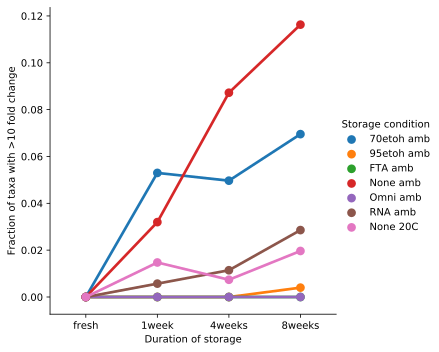

In [21]:
graph = sns.catplot(x="time", y="value", kind="point", hue='group', data=tidy_data3, order=['fresh','1week', '4weeks', '8weeks'])
#graph.set(ylim=(-.01, 0.12))
graph.set_axis_labels("Duration of storage", "Fraction of taxa with >10 fold change")
graph._legend.set_title("Storage condition")
graph.savefig('blooms_fresh_amb_bl.png')
graph.savefig('blooms_fresh_amb_bl.svg', format='svg', dpi=1200)

# Correlation plots

### frozen

In [ ]:
os.mkdir('correlation-images-frozen-bl')

In [ ]:
#for samples where sample preservative method = None
#for this condition we will use the samples that were stored at -20C for 1 week as the baseline 
#these baseline samples also had no preservative
#thus, the baseline samples for EVERY subgroup are the none,1week,20C samples

#create dataframe of baseline samples
none_bl = meta[meta.sample_preservation_method == 'None']
none_1week_bl = none_bl[none_bl.duration_of_storage == '1week']
none_1week_20C_bl = none_1week_bl[none_1week_bl.sample_storage_temp_treatment_week_added == '20C']

pres_sep = []

for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    for row in preservation_df['sample_preservation_method']:
        if row == 'None':
            pres_sep.append(preservation_df)
            break

subsets_w_bl = {}

for pres_grp in pres_sep:
    for (pres, temp), temperature_df in pres_grp.groupby(['sample_preservation_method',
                                                           'sample_storage_temp_treatment_week_added']):
        new_df = pd.concat([none_1week_20C_bl,temperature_df])
        subsets_w_bl[(pres, temp)] = new_df

In [ ]:
for key, value in subsets_w_bl.items():
    
    if key == ('None', '20C'):

        string =  ' '.join(key)

        #merge metadata subsets with baseline with taxonomy
        metafec6 = pd.merge(value, fec6s, left_index=True, right_on='sample')

        #create new column 
        metafec6['taxa_subject'] = metafec6['taxa'] + metafec6['host_subject_id']

        #subtract out duplicates and pivot
        df = metafec6.drop_duplicates(subset = ['taxa_subject', 'duration_of_storage'], keep = 'first')
        fecpiv = df.pivot(index='taxa_subject', columns='duration_of_storage', values='counts')
        
        # check pearson correlation
        x = fecpiv['1week']
        y = fecpiv['8weeks']
        corr = stats.pearsonr(x, y)
        int1, int2 = corr
        
        corr_rounded = round(int1, 2)
        corr_str = str(corr_rounded)

        #make correlation plots
        ax=sns.lmplot(x='1week',y='8weeks',data=fecpiv, height=3.8)
        ax.set(yscale='log')
        ax.set(xscale='log')
        plt.xlim(0.00001, 1)
        plt.ylim(0.00001, 1)
        plt.title(string + ' (%s)' %corr_str)

        ax.savefig('correlation-images-frozen-bl/%s.png'%string)
        ax.savefig('correlation-images-frozen-bl/%s.svg'%string, format='svg',dpi=1200)


### not frozen (fresh, amb bl)

In [ ]:
os.mkdir('correlation-images-fresh-bl')

In [ ]:
#for these conditions we will use the fresh samples as baseline
#thus within each preservative, the baseline samples are fresh,amb

#list of metadata preservative subgroups to create graphs for (6)
pres_sep = [] 

#list of baselines
bl = []

#keep dataframes for each preservation method, except None
for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    pres_sep.append(preservation_df)

    #create amb, fresh baseline for each preservative (all fresh are also amb)
    amb_fresh_bl = preservation_df[preservation_df.duration_of_storage == 'fresh']
    bl.append(amb_fresh_bl)

#list of preservative and temperature subgroups with their baseline samples
subsets_w_bl = {}

for etoh70_df, etoh70_bl in zip(pres_sep, bl):    
    #create list of temperature subgroups with their baseline samples
    
    for (pres, temp), temperature_df in etoh70_df.groupby(['sample_preservation_method',
                                                           'sample_storage_temp_treatment_week_added']):
        new_df = pd.concat([etoh70_bl,temperature_df])
        subsets_w_bl[(pres, temp)] = new_df

In [ ]:
for key, value in subsets_w_bl.items():
    
    string =  ' '.join(key)
    
    #merge metadata subsets with baseline with taxonomy
    metafec6 = pd.merge(value, fec6s, left_index=True, right_on='sample')

    #create new column 
    metafec6['taxa_subject'] = metafec6['taxa'] + metafec6['host_subject_id']

    #subtract out duplicates and pivot
    df = metafec6.drop_duplicates(subset = ['taxa_subject', 'duration_of_storage'], keep = 'first')
    fecpiv = df.pivot(index='taxa_subject', columns='duration_of_storage', values='counts')
    fecpiv_no_na = fecpiv.dropna()

    # check pearson correlation
    x = fecpiv_no_na['fresh']
    y = fecpiv_no_na['8weeks']
    corr = stats.pearsonr(x, y)
    int1, int2 = corr

    corr_rounded = round(int1, 2)
    corr_str = str(corr_rounded)
    
    #make correlation plots
    ax=sns.lmplot(x='fresh',y='8weeks',data=fecpiv_no_na, height=3.8)
    ax.set(yscale='log')
    ax.set(xscale='log')
    plt.xlim(0.00001, 1)
    plt.ylim(0.00001, 1)
    plt.title(string + ' (%s)' %corr_str)

    ax.savefig('correlation-images-fresh-bl/%s.png'%string)
    ax.savefig('correlation-images-fresh-bl/%s.svg'%string, format='svg',dpi=1200)


### not frozen (none, fresh, amb BL)

In [ ]:
os.mkdir('correlation-images-none-fresh-bl')

In [ ]:
#for these conditions we will use the fresh samples as baseline
#thus within each preservative, the baseline samples are fresh,amb

#list of metadata preservative subgroups to create graphs for (6)
pres_sep = [] 

#list of baselines
bl = []

#keep dataframes for each preservation method, except None
for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    pres_sep.append(preservation_df)

for preservation, preservation_df in meta.groupby('sample_preservation_method'):
    if preservation == 'None':
        #create amb, fresh baseline for each preservative (all fresh are also amb)
        amb_fresh_bl = preservation_df[preservation_df.duration_of_storage == 'fresh']
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)
        bl.append(amb_fresh_bl)

#list of preservative and temperature subgroups with their baseline samples
subsets_w_bl = {}

for etoh70_df, etoh70_bl in zip(pres_sep, bl):
    #create list of temperature subgroups with their baseline samples
    
    for (pres, temp), temperature_df in etoh70_df.groupby(['sample_preservation_method',
                                                           'sample_storage_temp_treatment_week_added']):
        new_df = pd.concat([etoh70_bl,temperature_df])
        subsets_w_bl[(pres, temp)] = new_df

In [ ]:
for key, value in subsets_w_bl.items():
    
    string =  ' '.join(key)
    
    #merge metadata subsets with baseline with taxonomy
    metafec6 = pd.merge(value, fec6s, left_index=True, right_on='sample')

    #create new column 
    metafec6['taxa_subject'] = metafec6['taxa'] + metafec6['host_subject_id']

    #subtract out duplicates and pivot
    df = metafec6.drop_duplicates(subset = ['taxa_subject', 'duration_of_storage'], keep = 'first')
    fecpiv = df.pivot(index='taxa_subject', columns='duration_of_storage', values='counts')
    fecpiv_no_na = fecpiv.dropna()

    # check pearson correlation
    x = fecpiv_no_na['fresh']
    y = fecpiv_no_na['8weeks']
    corr = stats.pearsonr(x, y)
    int1, int2 = corr

    corr_rounded = round(int1, 2)
    corr_str = str(corr_rounded)
    
    #make correlation plots
    ax=sns.lmplot(x='fresh',y='8weeks',data=fecpiv_no_na, height=3.8)
    ax.set(yscale='log')
    ax.set(xscale='log')
    plt.xlim(0.00001, 1)
    plt.ylim(0.00001, 1)
    plt.title(string + ' (%s)' %corr_str)

    #ax.savefig('correlation-images-none-fresh-bl/%s.png'%string)
    ax.savefig('correlation-images-none-fresh-bl/%s.svg'%string, format='svg',dpi=1200)